In [1]:
from utils import *
#pd.set_option('display.max.rows', None)
import warnings
import itertools
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore")

In [2]:
path_domestic='./data/domestic/'
domestic_df = preprocess_data(path_domestic)
#domestic_df.to_csv('./domestic_df.csv')

path_inter='./data/inter_airline_flight/'
inter_df_dom = preprocess_data(path_inter)
#inter_df.to_csv('./inter_df.csv')

path_inter_dom_air='./data/inter_flight_dom_airline/'
inter_dom_air_df = preprocess_data(path_inter_dom_air)
#inter_dom_air_df.to_csv('./inter_dom_air_df.csv')

In [3]:
inter_df = pd.concat([inter_dom_air_df, inter_df_dom], axis=0)
inter_df = inter_df.groupby('date').sum().sort_index()

all_df = pd.concat([inter_df, domestic_df], axis=0)
all_df = all_df.groupby('date').sum().sort_index()

domestic_df = domestic_df.set_index('date', drop=True).sort_index()

def acc_bar_mosafer(df):
    df['freight'] = df['bar_exit'] + df['bar_entry']
    df['passenger'] = df['mosafer_exit'] + df['mosafer_entry']
    df = df.drop(['jalali_date', 'tedad_parvaz_exit', 'tedad_parvaz_entry',
        'post_exit', 'post_entry', 'bar_exit', 'bar_entry', 'mosafer_exit',
        'mosafer_entry'], axis=1)
    return df

In [4]:
domestic_df = acc_bar_mosafer(domestic_df)
inter_df = acc_bar_mosafer(inter_df)
all_df = acc_bar_mosafer(all_df)

In [5]:
def model_sarima(data_type='int', normalization=False, chosen_column='passenger', df=inter_df):
    
    path = f'D:/University related/jahromi/code/results/{data_type}/{chosen_column}/'
    try:
        os.makedirs(path)
    except:
        pass
    os.chdir(path)
    chosen_norm = [chosen_column]
    
    # to bring the period to the first day of each month
    data = df.resample('MS').sum().copy()

    # Dicky-fuller test
    dicky_fuller = perform_adf_test(data[chosen_norm])
    dicky_df = pd.DataFrame.from_dict(dicky_fuller)
    dicky_df.to_csv('dicky_fuller.csv')

    decomposition = sm.tsa.seasonal_decompose(data[chosen_norm], model='additive')
    plt.rcParams.update({'figure.figsize': (20,10)})
    fig = decomposition.plot()
    plt.savefig('./decomposition.svg')

    plt.rcParams.update({'figure.figsize': (5,5)})
    plot_acf(data[chosen_norm])
    plt.savefig('./acf.svg')

    plt.rcParams.update({'figure.figsize': (5,5)})
    plot_pacf(data[chosen_norm])
    plt.savefig('./pacf.svg')

    # Calculate the difference between date points
    #data=data[chosen_norm].diff().dropna(axis=0)
    data=data[chosen_norm]

    if normalization:
        data=data.apply(lambda x: (x - x.min()) / (x.max()-x.min()))

    y = pd.Series(data=data[chosen_column].values, index=data.index)

    # Define the p, d and q parameters to take any value between 0 and 3
    p = d = q = range(1, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    result = dict()
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
                result.update({results.bic:[param, param_seasonal]})
                
            except:
                continue

    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=result[min(result.keys())][0],
                                    seasonal_order=result[min(result.keys())][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    df_out = data[chosen_column].to_frame()

    df_out['pred'] = results.get_prediction(start=pd.to_datetime('2011-05-01'), end=pd.to_datetime('2031-12-01'), dynamic=False).predicted_mean
    df_out['residual'] = abs(df_out['pred'] - df_out[chosen_column])
    rmse = np.sqrt(np.mean(df_out['residual']**2))
    mape = round(np.mean(abs(df_out['residual']/data[chosen_column])),4)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Percent Error:', mape)

    error = dict()
    error.update({'Root Mean Squared Error':[rmse]})
    error.update({'Mean Absolute Percent Error:': [mape]})
    print(error)
    error_df = pd.DataFrame.from_dict(error)
    error_df.to_csv('error.csv')
    df_out.to_csv('sarima_prediction.csv')

    #%% Forecast 5y
    years = 10
    pred_uc = results.get_forecast(steps=12*years)
    pred_future = pred_uc.predicted_mean

    pred_future.to_csv('sarima_future.csv')

    results_1 = results.summary().tables[0].as_html()
    results_2 = results.summary().tables[1].as_html()
    results_3 = results.summary().tables[2].as_html()

    results_1 = pd.read_html(results_1, header=0, index_col=0)[0]
    results_2 = pd.read_html(results_2, header=0, index_col=0)[0]
    results_3 = pd.read_html(results_3, header=0, index_col=0)[0]

    results_1.to_csv('./results_1.csv')
    results_2.to_csv('./results_2.csv')
    results_3.to_csv('./results_3.csv')

    results.plot_diagnostics(figsize=(20, 20))
    plt.savefig('./diagnostics.svg')

In [6]:
def model_sarima_intervention(data_type='int', normalization=False, chosen_column='passenger', df=inter_df, intervention=3):
    path = f'D:/University related/jahromi/code/results/{data_type}/{chosen_column}/'
    try:
        os.makedirs(path)
    except:
        pass
    os.chdir(path)
    chosen_norm = [chosen_column]

    # to bring the period to the first day of each month
    data = df.resample('MS').sum().copy()

    new_date = pd.Series(index = pd.date_range(start="2022-01-01" , end="2032-01-01" , freq='M')).to_frame()
    new_date.index.names = ['date']
    data = pd.concat([data, new_date], axis=0).drop(0, axis=1).fillna(0)

    #endog = data[chosen_norm].diff().iloc[1:]
    endog = data[chosen_norm]
    exog_full = sm.add_constant(data).drop(['freight', 'passenger'], axis=1)

    exog_full['intervention'] = np.zeros(len(exog_full))

    if intervention == 3:
        exog_full.loc['2020-02':'2020-05', 'intervention'] = 1
    else: # intervention == 6
        exog_full.loc['2020-02':'2020-08', 'intervention'] = 1

    exog = exog_full.iloc[0:129]
    exog_fcast = exog_full.iloc[129:]
    endog = endog.iloc[0:129]

    # Define the p, d and q parameters to take any value between 0 and 3
    p = d = q = range(1, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    result = dict()
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(endog,
                                                exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
                result.update({results.bic:[param, param_seasonal]})
            except:
                continue
            
    mod = sm.tsa.statespace.SARIMAX(endog,
                                    exog=exog,
                                    order=result[min(result.keys())][0],
                                    seasonal_order=result[min(result.keys())][1],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit(maxiter=1000)

    results.summary()

    results_1 = results.summary().tables[0].as_html()
    results_2 = results.summary().tables[1].as_html()
    results_3 = results.summary().tables[2].as_html()

    results_1 = pd.read_html(results_1, header=0, index_col=0)[0]
    results_2 = pd.read_html(results_2, header=0, index_col=0)[0]
    results_3 = pd.read_html(results_3, header=0, index_col=0)[0]

    results_1.to_csv(f'./results_1_intervention_{intervention}_months.csv')
    results_2.to_csv(f'./results_2_intervention_{intervention}_months.csv')
    results_3.to_csv(f'./results_3_intervention_{intervention}_months.csv')

    prediction =results.forecast(len(exog_fcast), exog=exog_fcast)

    prediction.to_frame().to_csv(f'prediction_intervention_{intervention}.csv')

    df_out = endog
    df_out['pred'] = results.get_prediction(start=pd.to_datetime('2011-05-01'), dynamic=False).predicted_mean
    df_out['residual'] = abs(df_out['pred'] - df_out[chosen_column])
    rmse = np.sqrt(np.mean(df_out['residual']**2))
    mape = round(np.mean(abs(df_out['residual']/data[chosen_column])),4)

    error = dict()
    error.update({'Root Mean Squared Error':[rmse]})
    error.update({'Mean Absolute Percent Error': [mape]})
    error_df = pd.DataFrame.from_dict(error)
    error_df.to_csv(f'error_intervention_{intervention}_months.csv')

In [7]:
model_sarima_intervention(data_type='int', normalization=False, chosen_column='passenger', df=inter_df, intervention=3)
model_sarima_intervention(data_type='dom', normalization=False, chosen_column='passenger', df=domestic_df, intervention=3)
model_sarima_intervention(data_type='all', normalization=False, chosen_column='passenger', df=all_df, intervention=3)

model_sarima_intervention(data_type='int', normalization=False, chosen_column='freight', df=inter_df, intervention=3)
model_sarima_intervention(data_type='dom', normalization=False, chosen_column='freight', df=domestic_df, intervention=3)
model_sarima_intervention(data_type='all', normalization=False, chosen_column='freight', df=all_df, intervention=3)

model_sarima_intervention(data_type='int', normalization=False, chosen_column='passenger', df=inter_df, intervention=6)
model_sarima_intervention(data_type='dom', normalization=False, chosen_column='passenger', df=domestic_df, intervention=6)
model_sarima_intervention(data_type='all', normalization=False, chosen_column='passenger', df=all_df, intervention=6)
 
model_sarima_intervention(data_type='int', normalization=False, chosen_column='freight', df=inter_df, intervention=6)
model_sarima_intervention(data_type='dom', normalization=False, chosen_column='freight', df=domestic_df, intervention=6)
model_sarima_intervention(data_type='all', normalization=False, chosen_column='freight', df=all_df, intervention=6)

ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2716.311011385513
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2927.78802168148
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2927.78802168148
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 3391.1067644690115
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2976.330819297522
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2976.330819297522
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2714.433345450335
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2928.9033955622617
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2928.9033955622617
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 3391.2791513795864
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2992.0459155738
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2992.0459155738


ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2712.3657507233333
Root Mean Squared Error: 146760.02092613513
Mean Absolute Percent Error: 0.3864
{'Root Mean Squared Error': [146760.02092613513], 'Mean Absolute Percent Error:': [0.3864]}
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2926.4171271627156
Root Mean Squared Error: 420934.73104948987
Mean Absolute Percent Error: 0.1186
{'Root Mean Squared Error': [420934.73104948987], 'Mean Absolute Percent Error:': [0.1186]}
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2926.4171271627156
Root Mean Squared Error: 420934.73104948987
Mean Absolute Percent Error: 0.1186
{'Root Mean Squared Error': [420934.73104948987], 'Mean Absolute Percent Error:': [0.1186]}
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 3387.7064072458566
Root Mean Squared Error: 3386036.6653922047
Mean Absolute Percent Error: 0.1668
{'Root Mean Squared Error': [3386036.6653922047], 'Mean Absolute Percent Error:': [0.1668]}
ARIMA(1, 1, 1) x (1, 1, 1, 12) - AIC: 2987.972886520942
Root Mean Squared Error: 499

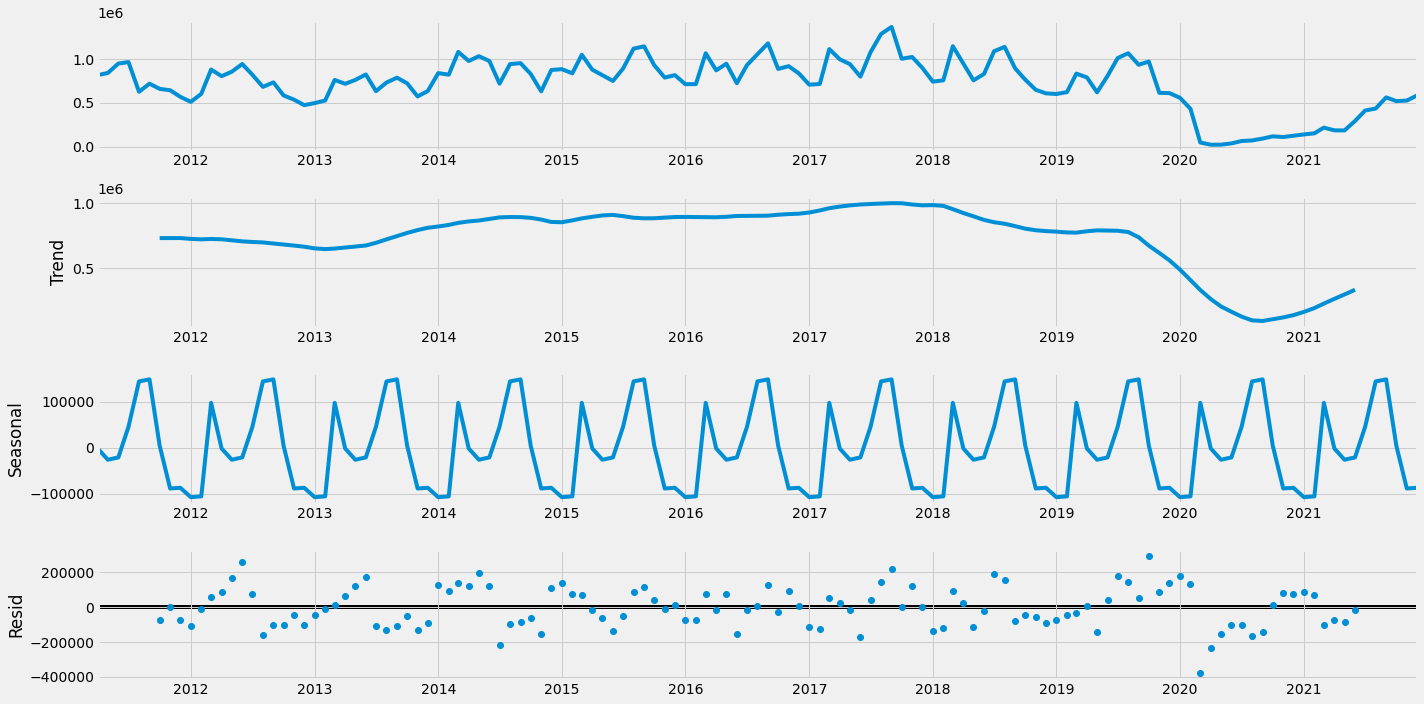

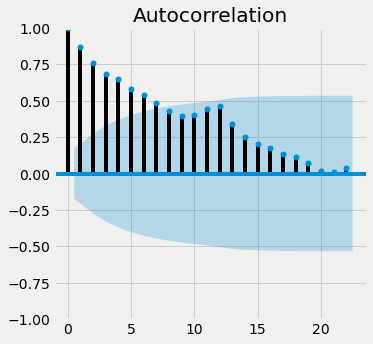

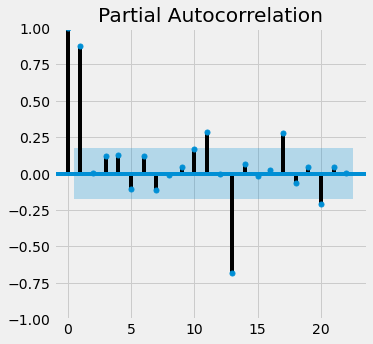

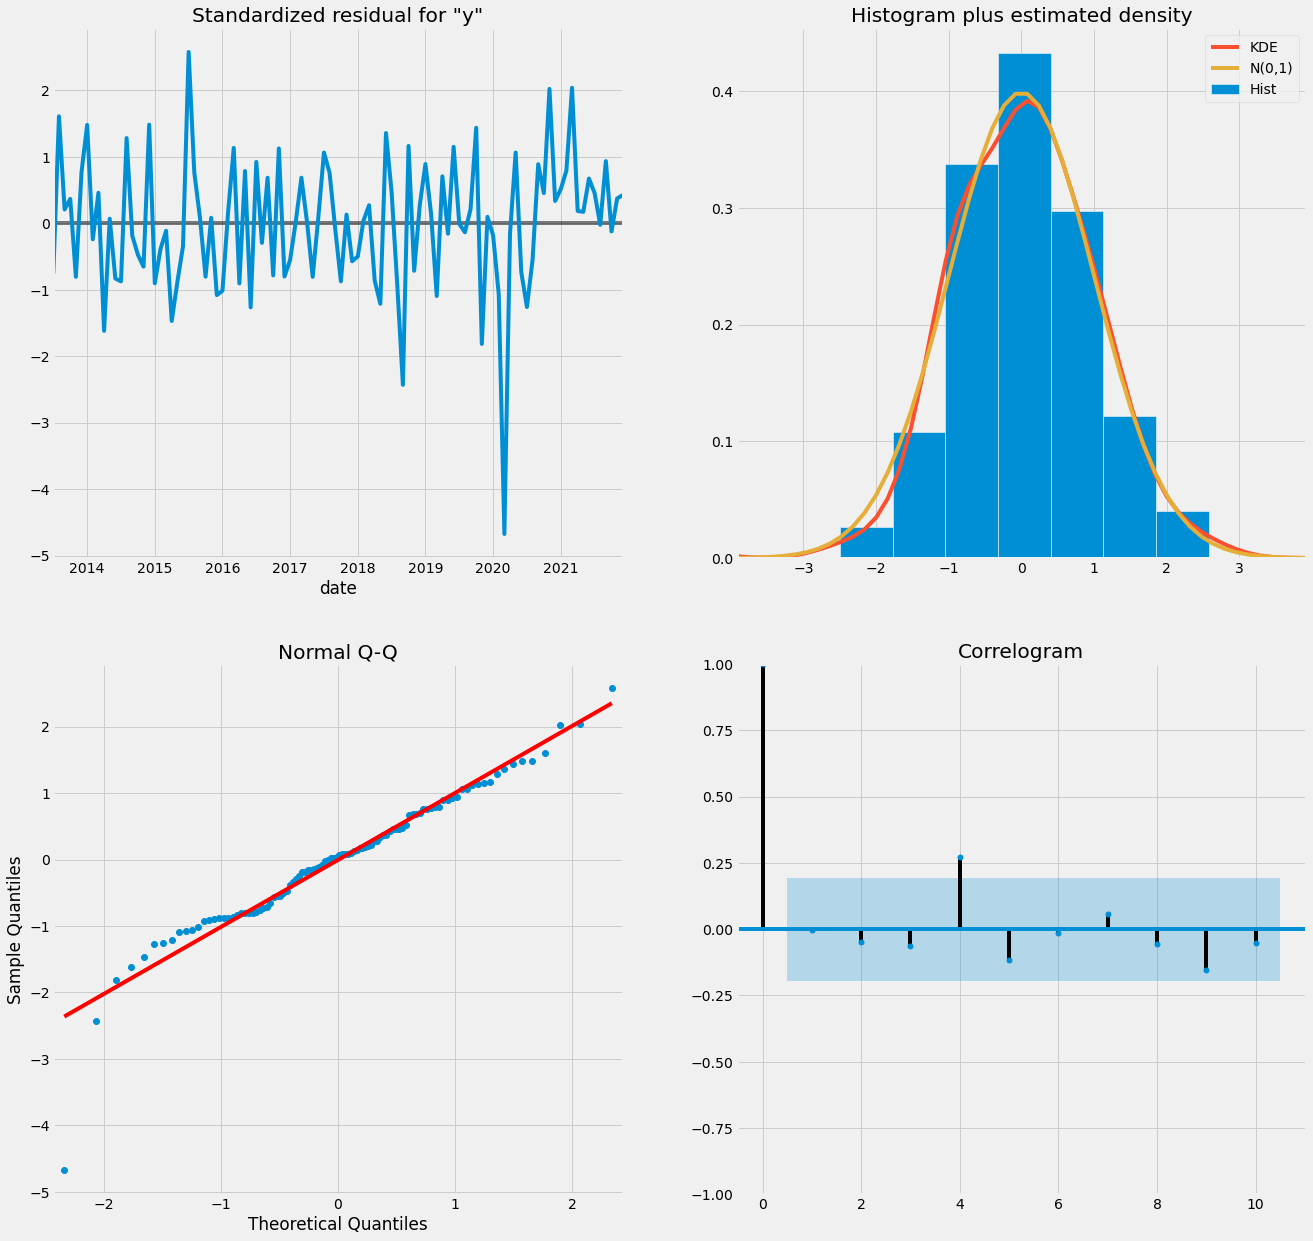

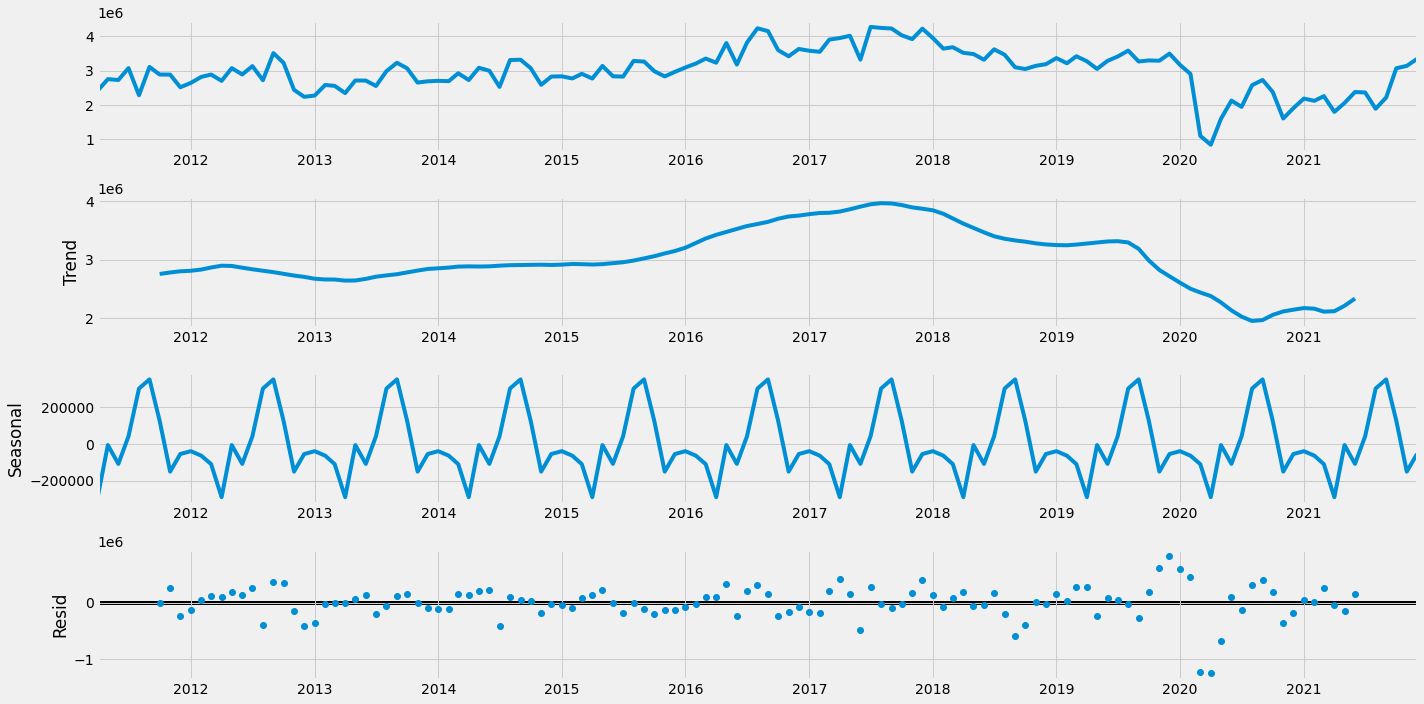

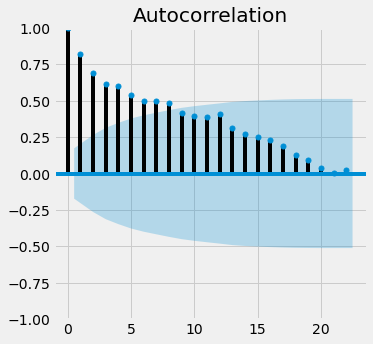

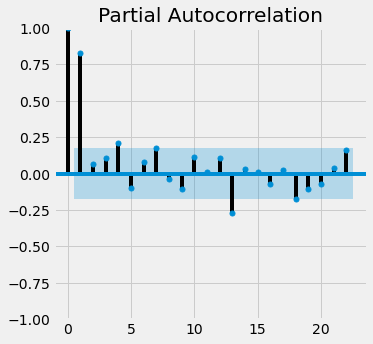

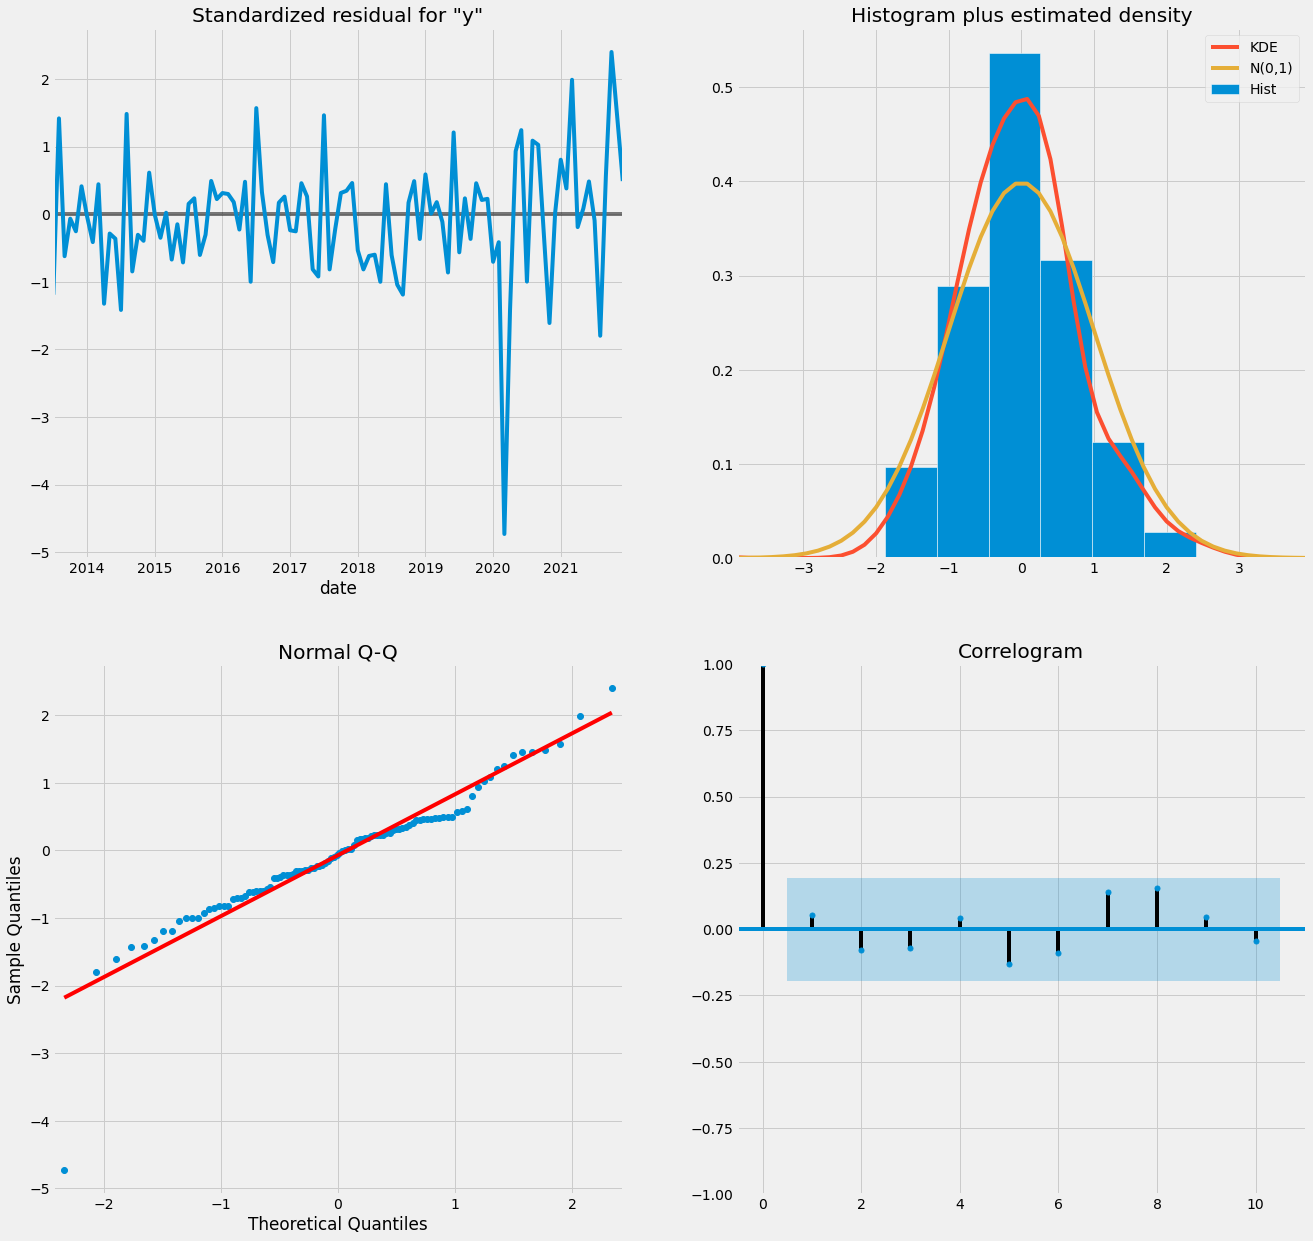

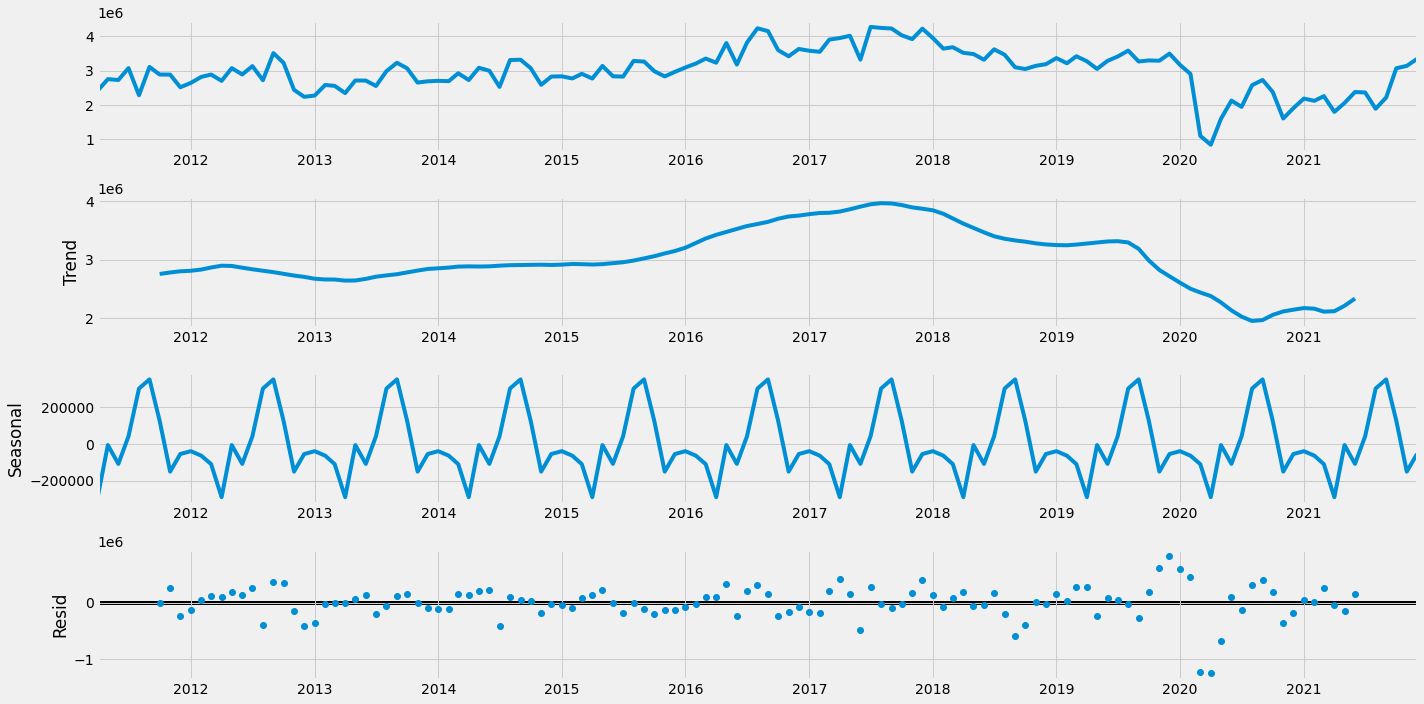

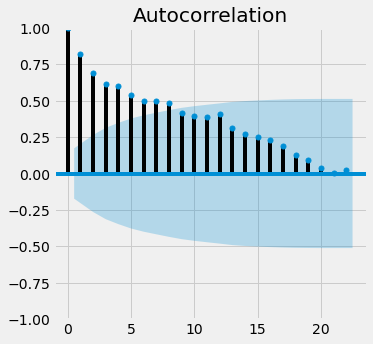

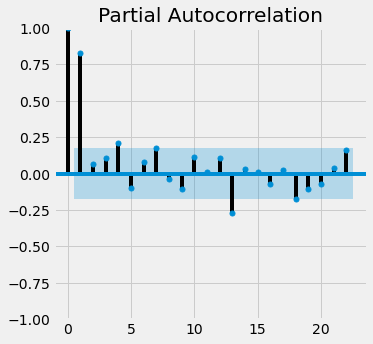

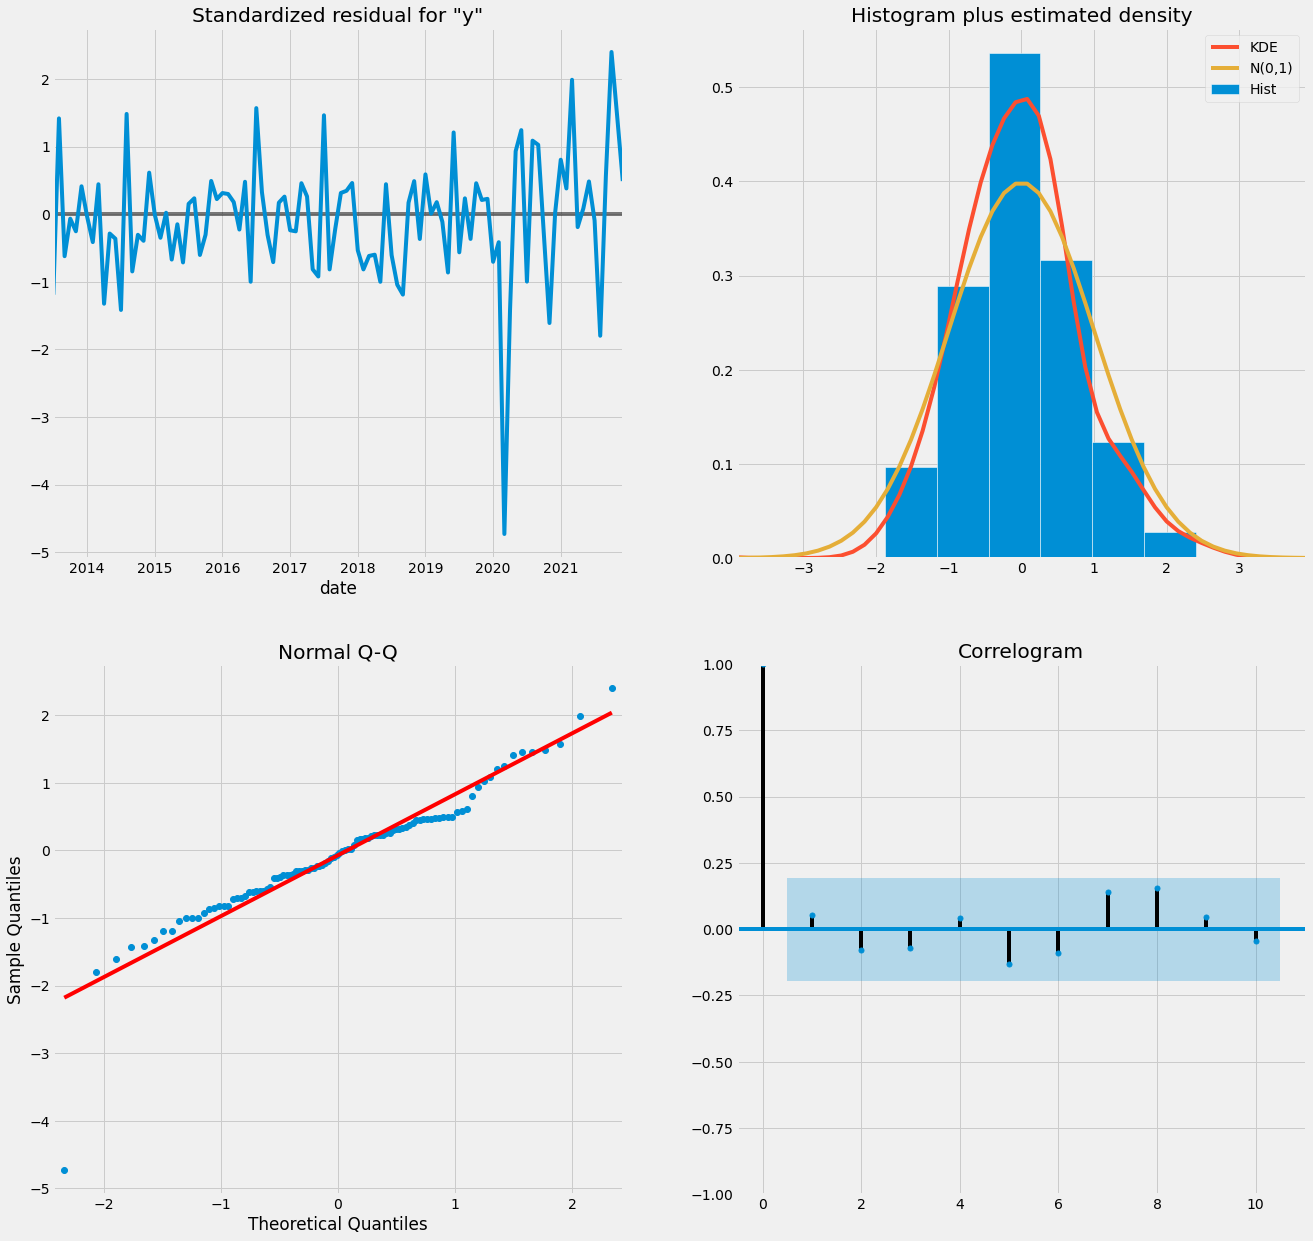

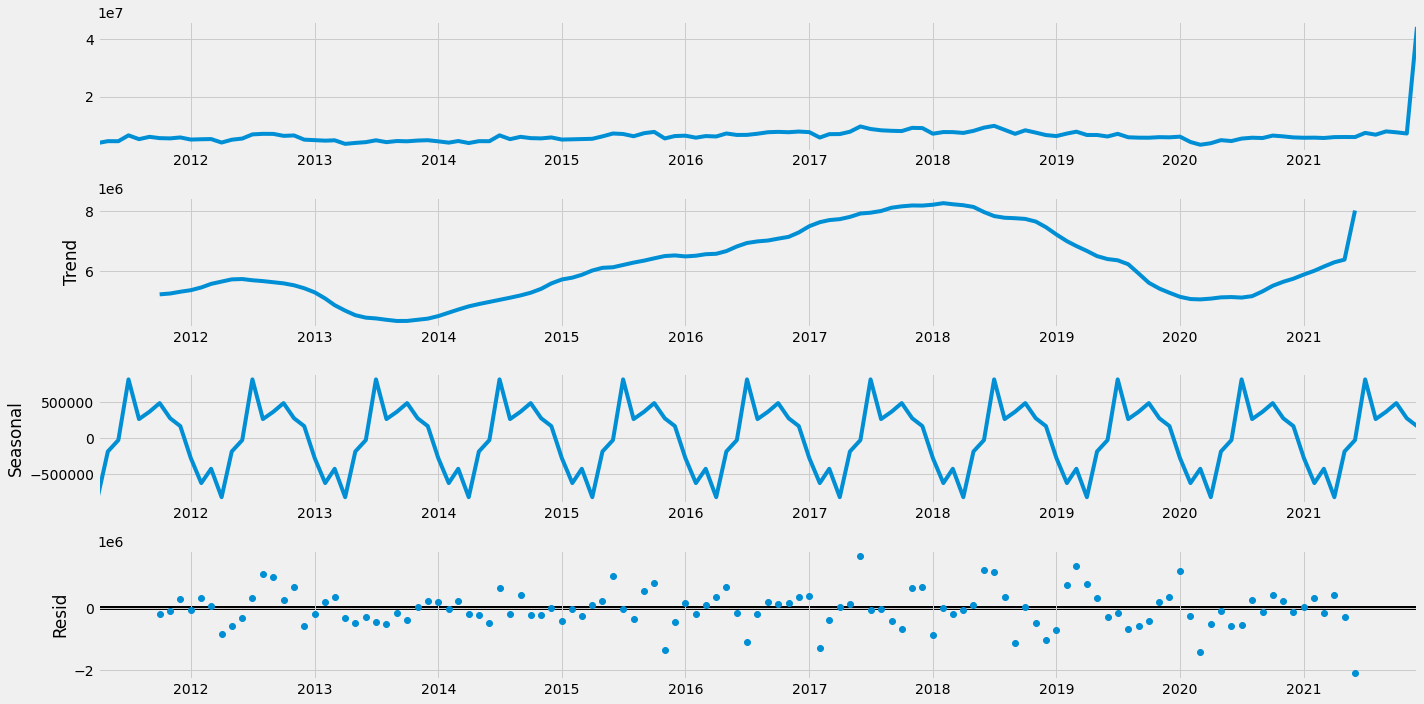

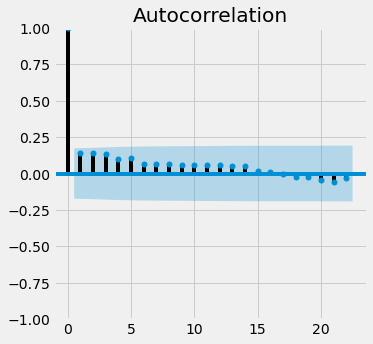

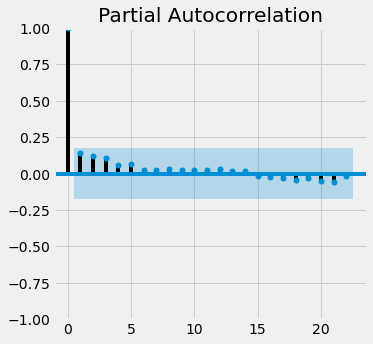

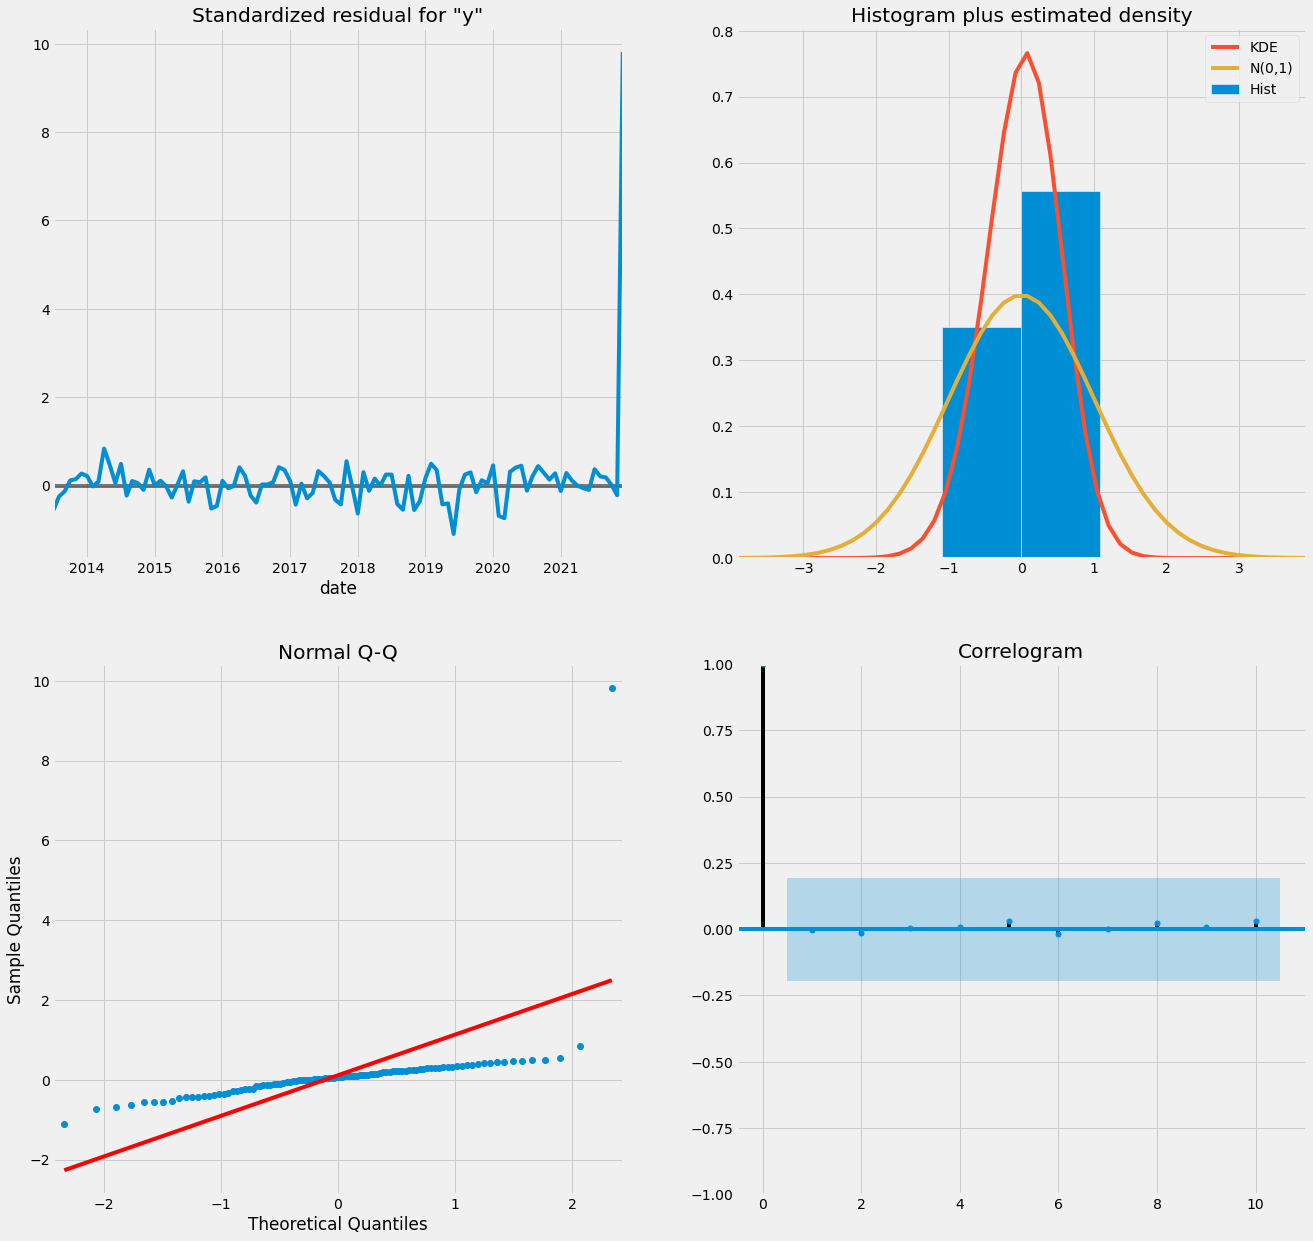

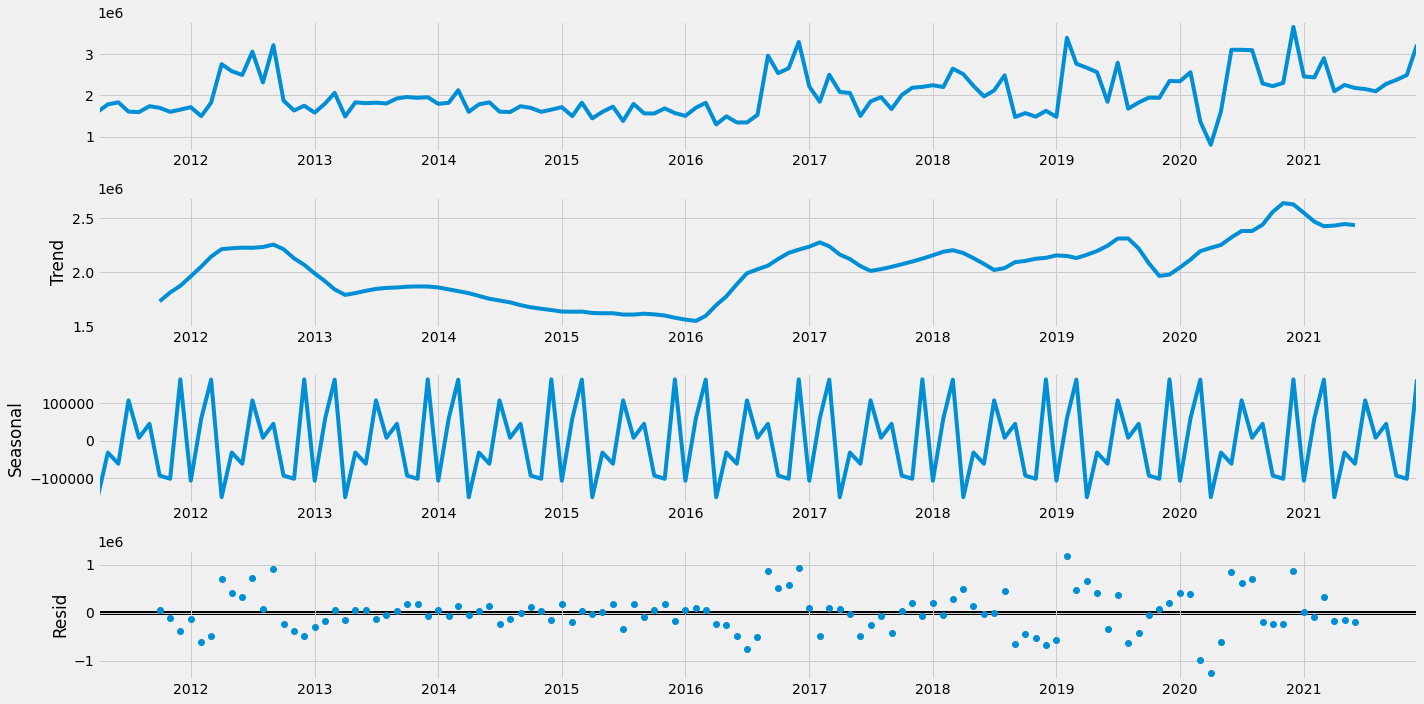

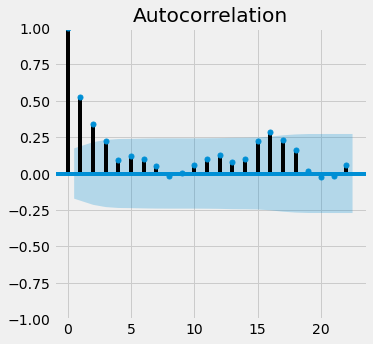

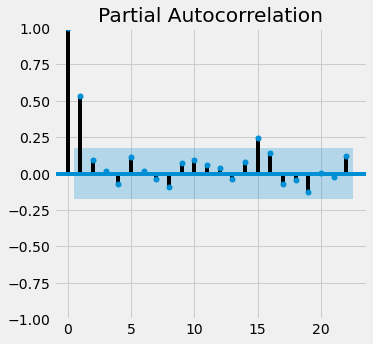

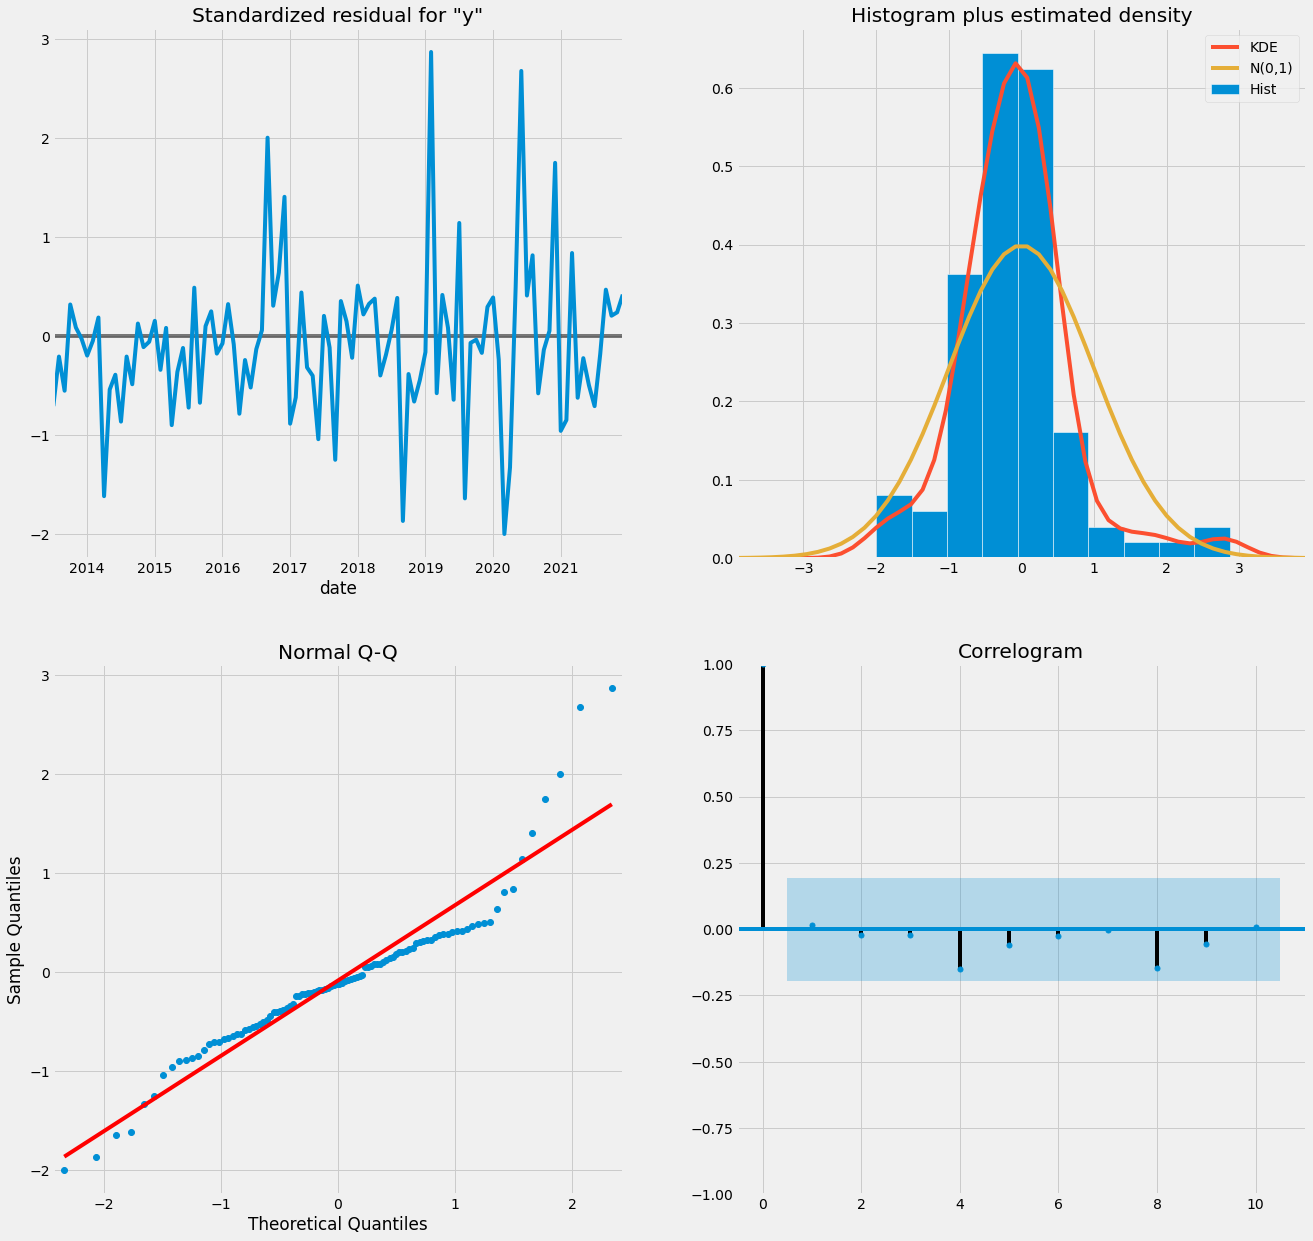

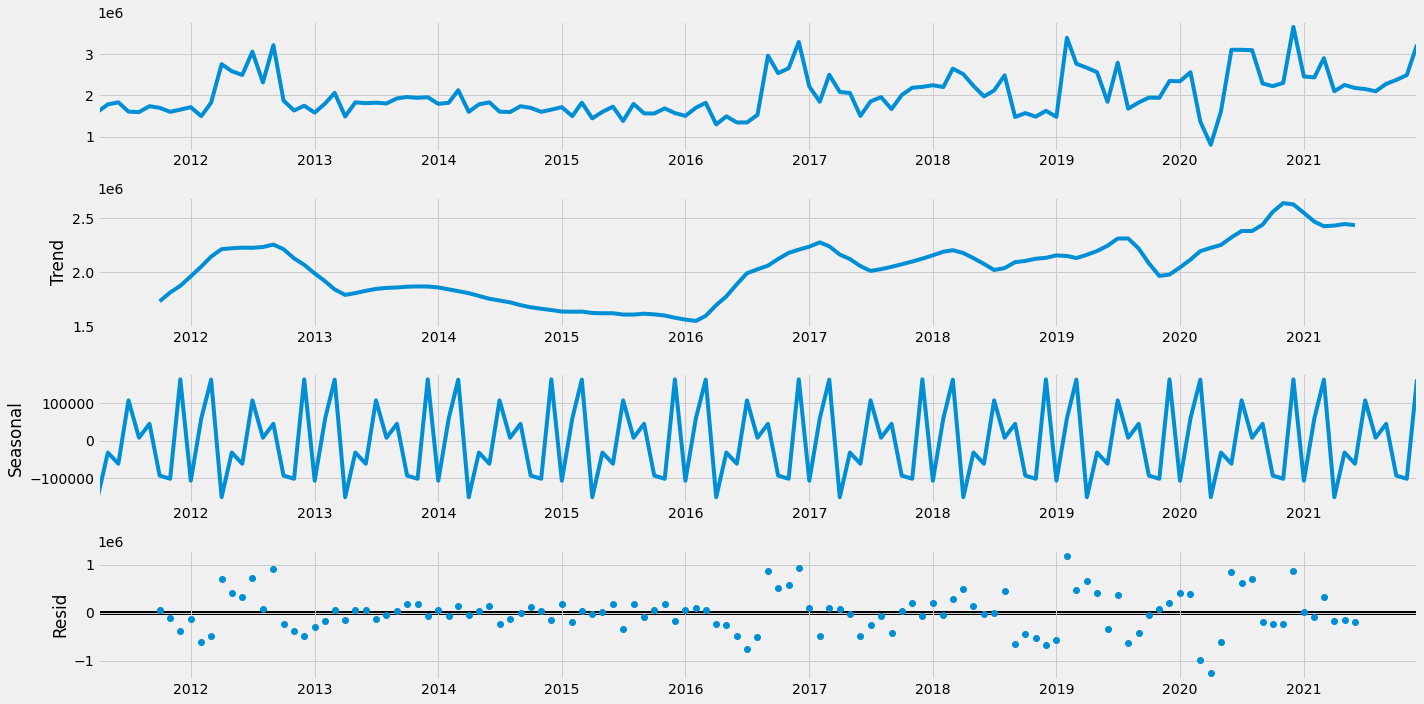

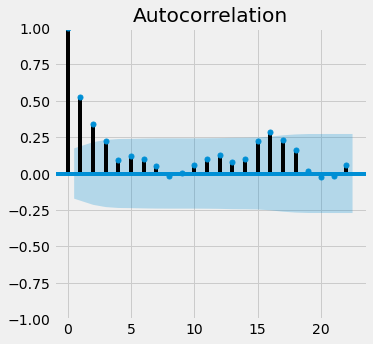

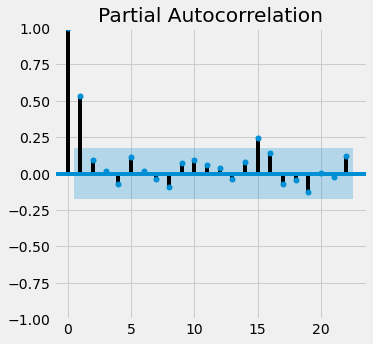

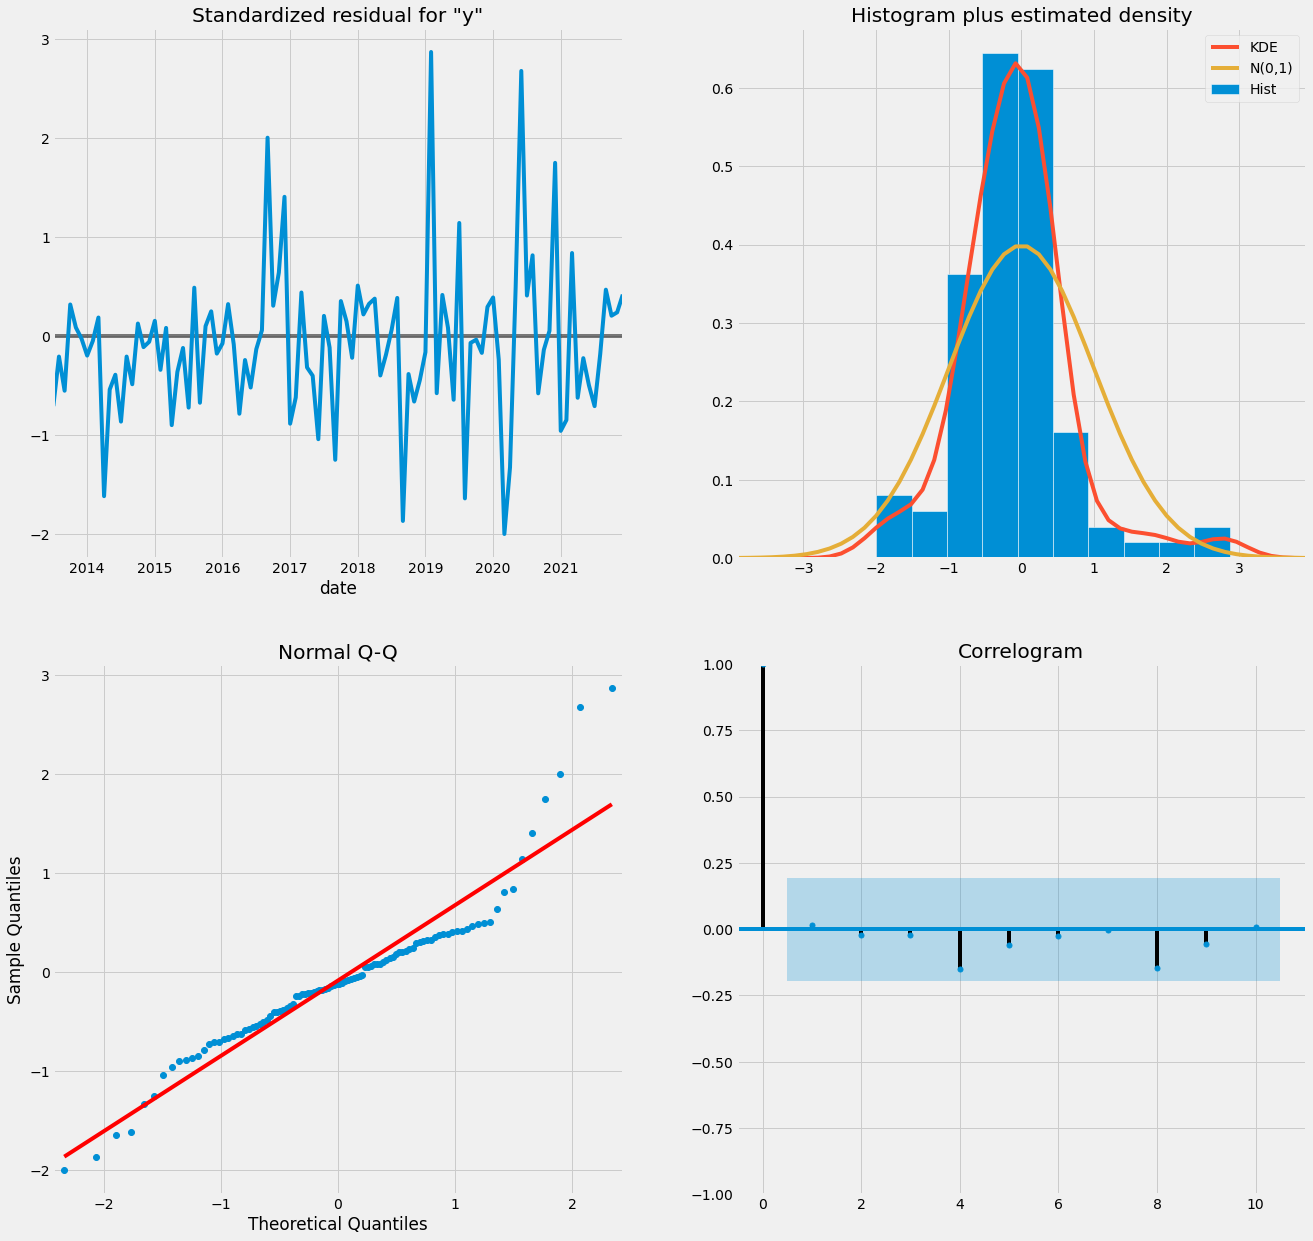

In [8]:
model_sarima(data_type='int', normalization=False, chosen_column='passenger', df=inter_df)
model_sarima(data_type='dom', normalization=False, chosen_column='passenger', df=domestic_df)
model_sarima(data_type='all', normalization=False, chosen_column='passenger', df=all_df)

model_sarima(data_type='int', normalization=False, chosen_column='freight', df=inter_df)
model_sarima(data_type='dom', normalization=False, chosen_column='freight', df=domestic_df)
model_sarima(data_type='all', normalization=False, chosen_column='freight', df=all_df)

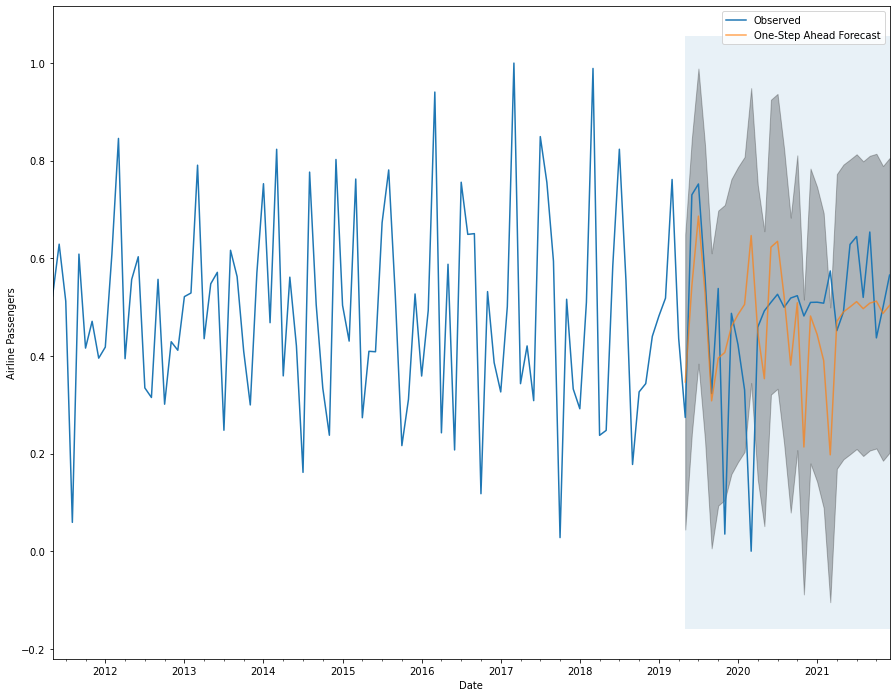

The Mean Squared Error of our forecasts is 0.03


In [ ]:
start_date = '2019-05-01'
pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2011':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)


ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start_date), y.index[-1],
                alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = y[start_date:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))